In [1]:
import datetime
import warnings
import scipy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

from collections import OrderedDict

%matplotlib inline

warnings.filterwarnings("ignore")


In [2]:


# from sklearn import metrics, linear_model
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

# from scipy.optimize import curve_fit

# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "last_expr"

# pd.options.display.max_columns = 50


In [2]:
df = pd.read_csv('flights.jan.csv')


In [3]:
print('Dimensões do dataframe: ', df.shape)


Dimensões do dataframe:  (469968, 32)


# Limpeza


In [3]:
# informações de valores nulos e tipos das colunas

tab_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'tipo de dado'})

tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(
    index={0: 'valores nulos (contagem)'}))

tab_info = tab_info.append(pd.DataFrame(
    df.isnull().sum()/df.shape[0]*100).T.rename(index={0: 'valores nulos (%)'}))
tab_info


,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
tipo de dado,int64,int64,int64,int64,int64,object,int64,object,object,object,...,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
valores nulos (contagem),0,0,0,0,0,0,0,2782,0,0,...,12271,12955,0,0,457986,374017,374017,374017,374017,374017
valores nulos (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591955,0.0,0.0,...,2.611029,2.756571,0.0,0.0,97.450465,79.583504,79.583504,79.583504,79.583504,79.583504


In [3]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])


In [4]:
# Função que converte a string 'HHMM' em datetime.time

def formatar_horario(dado_orig):
    if pd.isnull(dado_orig):
        return np.nan
    else:
        if dado_orig == 2400:
            dado_orig = 0
        dado_orig = "{0:04d}".format(int(dado_orig))
        horario = datetime.time(int(dado_orig[0:2]), int(dado_orig[2:4]))
        return horario


# Função que combina a data e o horario para criar um datetime.datetime

def combinar_data_horario(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0], x[1])


# Função que combina duas colunas do dataframe para criar um formato datetime

def criar_horario_voo(df, col):
    lista = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            lista.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0, 0)
            lista.append(combinar_data_horario(cols))
        else:
            cols[1] = formatar_horario(cols[1])
            lista.append(combinar_data_horario(cols))
    return pd.Series(lista)


In [5]:
df['SCHEDULED_DEPARTURE'] = criar_horario_voo(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(formatar_horario)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(formatar_horario)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(formatar_horario)


In [6]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',
            'DEPARTURE_TIME', 'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]


,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [7]:
a_remover = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DATE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
             'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME', 'Unnamed: 0']

df.drop(a_remover, axis=1, inplace=True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
         'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME']]

df[:5]


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [8]:
valores_faltantes_df = df.isnull().sum(axis=0).reset_index()
valores_faltantes_df.columns = ['Variável', 'Valores faltantes']
valores_faltantes_df['Valores presentes (%)'] = (
    df.shape[0]-valores_faltantes_df['Valores faltantes'])/df.shape[0]*100
valores_faltantes_df.sort_values(
    'Valores presentes (%)').reset_index(drop=True)


,Variável,Valores faltantes,Valores presentes (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [9]:
df.dropna(inplace=True)


In [10]:
df.isnull().sum()


AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
SCHEDULED_TIME         0
ELAPSED_TIME           0
dtype: int64

# Comparando companhias aéreas


In [11]:
companhias_aereas = pd.read_csv('airlines.csv')
companhias_aereas


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [12]:
abrev_companhias = companhias_aereas.set_index('IATA_CODE')[
    'AIRLINE'].to_dict()


In [13]:
# Função que extrai parâmetros estatísticos a partir de um objeto groupby:

def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'contagem': group.count(), 'média': group.mean()}


In [14]:
# Criação de um dataframe com informações estatísticas de cada companhia:

estats_companhias = df['DEPARTURE_DELAY'].groupby(
    df['AIRLINE']).apply(get_stats).unstack()
estats_companhias = estats_companhias.sort_values('contagem')
estats_companhias


,min,max,contagem,média
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


## Gráficos


In [15]:
fonte = {'family': 'verdana', 'weight': 'bold', 'size': 15}
mpl.rc('font', **fonte)


In [16]:
# Extrair um subset de colunas e redefinir os nomes das companhias aéreas

df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abrev_companhias)


In [17]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen',
          'lightskyblue', 'lightcoral', 'yellowgreen', 'gold',
          'tomato', 'violet', 'aquamarine', 'chartreuse']


In [18]:
sns.set_style("darkgrid")


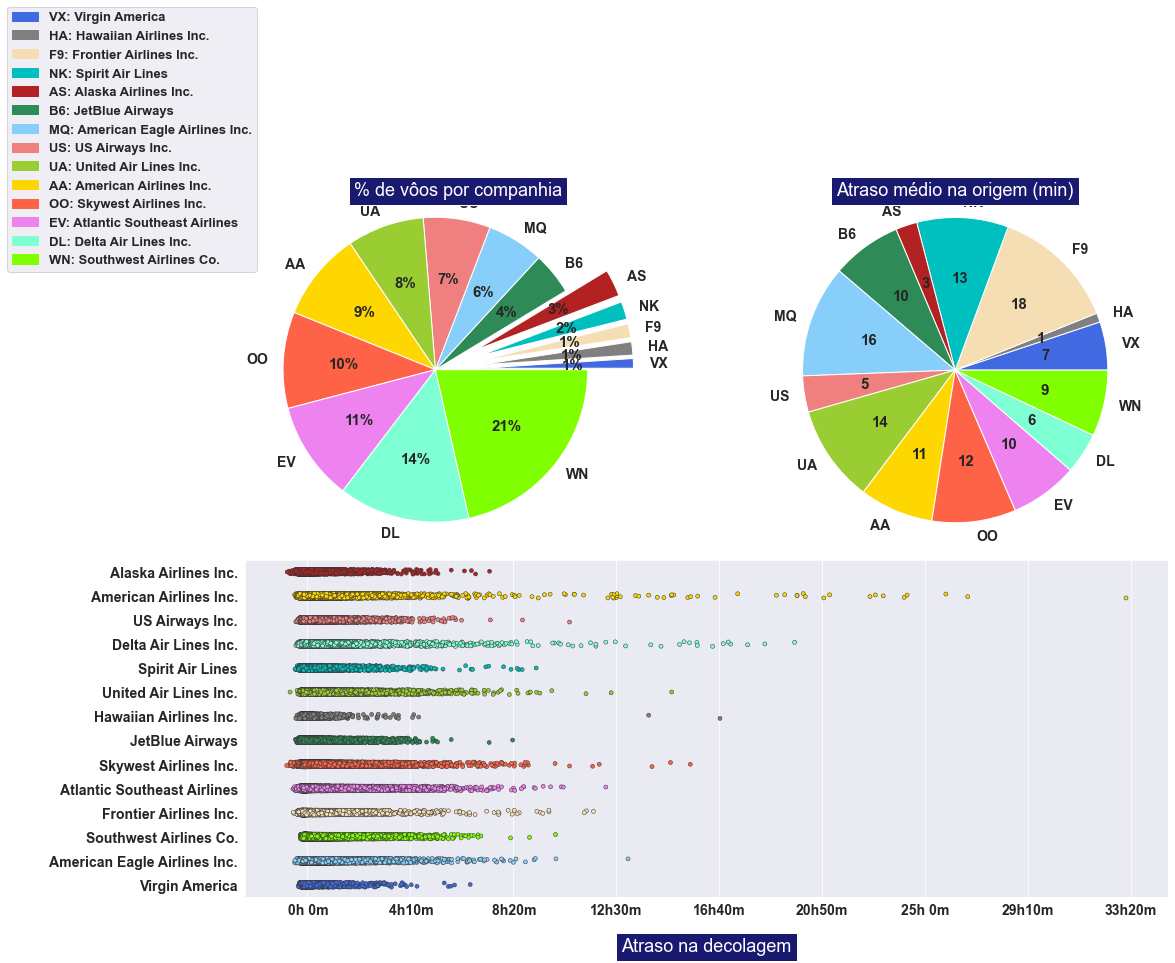

In [19]:
fig = plt.figure(1, figsize=(16, 15))
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# --
# Gráfico de pizza 1: número de vôos

labels = [s for s in estats_companhias.index]
sizes = estats_companhias['contagem'].values
explode = [0.3 if sizes[i] < 20000
           else 0.0 for i in range(len(abrev_companhias))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                    labels=labels, colors=colors,
                                    autopct='%1.0f%%', shadow=False,
                                    startangle=0)

for i in range(len(abrev_companhias)):
    texts[i].set_fontsize(14)

ax1.axis('equal')
ax1.set_title('% de vôos por companhia',
              bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# --
# Colocando a legenda: abreviação -> nome da companhia aérea

comp_handler = []
for i in range(len(abrev_companhias)):
    comp_handler.append(mpatches.Patch(color=colors[i],
                                       label=estats_companhias.index[i] + ': ' + abrev_companhias[estats_companhias.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9),
           fontsize=13, bbox_transform=plt.gcf().transFigure)

# --
# Gráfico de pizza 2: atraso médio ao decolar

sizes = estats_companhias['média'].values
sizes = [max(s, 0) for s in sizes]
explode = [0.0 if sizes[i] < 20000
           else 0.01 for i in range(len(abrev_companhias))]
patches, texts, autotexts = ax2.pie(sizes, explode=explode,
                                    labels=labels, colors=colors,
                                    shadow=False, startangle=0,
                                    autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abrev_companhias)):
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Atraso médio na origem (min)',
              bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# --
# Strip plot com todos os valores reportados para atrasos
# Redefinindo as cores para corresponder com os gráficos de pizza

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c',
          'yellowgreen', 'grey', 'seagreen', 'tomato', 'violet',
          'wheat', 'chartreuse', 'lightskyblue', 'royalblue']

# --

ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size=4,
                    palette=colors, data=df2, linewidth=0.5,
                    jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(
    *[int(y) for y in divmod(x, 60)])
    for x in ax3.get_xticks()])
plt.xlabel('Atraso na decolagem', fontsize=18,
           bbox={'facecolor': 'midnightblue', 'pad': 5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# --

plt.tight_layout(w_pad=3)


In [20]:
# Função que define como atrasos são agrupados

def tipo_atraso(x): return ((0, 1)[x > 5], 2)[x > 45]


df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(tipo_atraso)


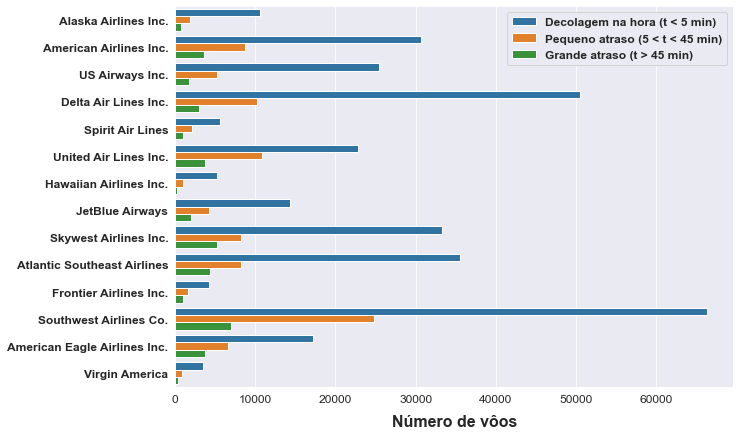

In [21]:
fig = plt.figure(1, figsize=(10, 7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)

# Substituindo as abreviações pelo nome completo das companhias aéreas e colocando os labels

labels = [abrev_companhias[item.get_text()]
          for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight='normal', rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=12, weight='bold', rotation=0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Número de vôos', fontsize=16, weight='bold', labelpad=10)


# Colocando a legenda

L = plt.legend(fontsize=12)
L.get_texts()[0].set_text('Decolagem na hora (t < 5 min)')
L.get_texts()[1].set_text('Pequeno atraso (5 < t < 45 min)')
L.get_texts()[2].set_text('Grande atraso (t > 45 min)')


plt.show()


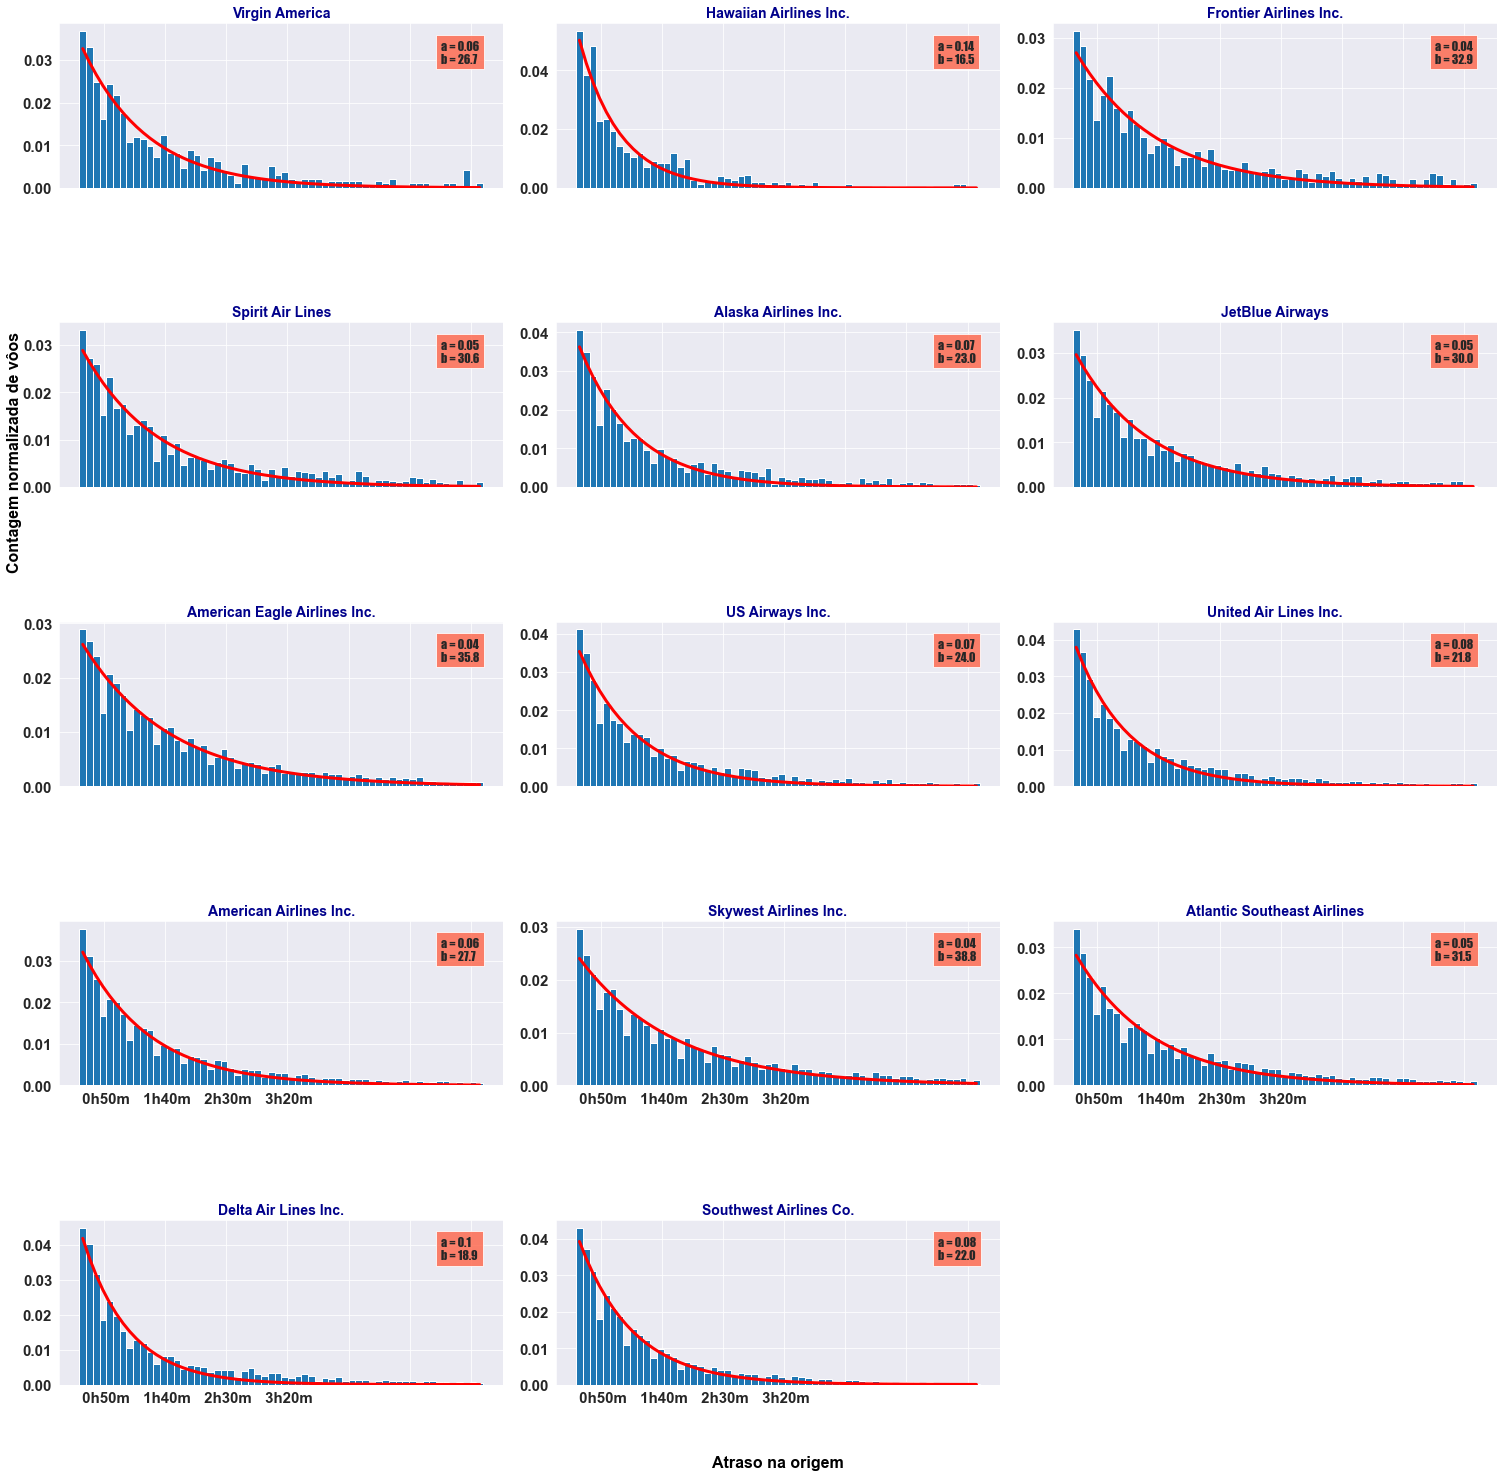

In [22]:
# Função modelo usada para fitar os histogramas
def fit_hist(x, a, b):
    return a * np.exp(-x/b)

# --


pontos = []
label_comp = []

fig = plt.figure(1, figsize=(21, 21))

i = 0
for nome_comp in [abrev_companhias[x] for x in estats_companhias.index]:
    i += 1
    ax = fig.add_subplot(5, 3, i)

    # Fitando a distribuição
    n, bins, patches = plt.hist(x=df2[df2['AIRLINE'] == nome_comp]
                                ['DEPARTURE_DELAY'], range=(15, 180),
                                density=True, bins=60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    popt, pcov = curve_fit(fit_hist, bin_centers, n, p0=[1, 2])

    # Contabilizando os resultados
    pontos.append(popt)
    label_comp.append(nome_comp)

    # Desenhando a curva fitada
    plt.plot(bin_centers, fit_hist(bin_centers, *popt), 'r-', linewidth=3)

    # Definindo as marcações em cada subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(
            *[int(y) for y in divmod(x, 60)])
            for x in ax.get_xticks()])

    # Título do subplot
    plt.title(nome_comp, fontsize=14, fontweight='bold', color='darkblue')

    # Labels dos eixos
    if i == 4:
        ax.text(-0.1, -0.5, 'Contagem normalizada de vôos', fontsize=16,
                rotation=90, color='k', horizontalalignment='center',
                transform=ax.transAxes)
    if i == 14:
        ax.text(0.5, -0.5, 'Atraso na origem', fontsize=16, rotation=0,
                color='k', horizontalalignment='center',
                transform=ax.transAxes)

    # Legenda: valores dos coeficientes a e b
    ax.text(0.86, 0.76, 'a = {}\nb = {}'.format(round(popt[0], 2),
            round(popt[1], 1)), style='italic', transform=ax.transAxes,
            fontsize=12, family='fantasy', bbox={'facecolor': 'tomato',
            'alpha': 0.8, 'pad': 5})

plt.tight_layout()


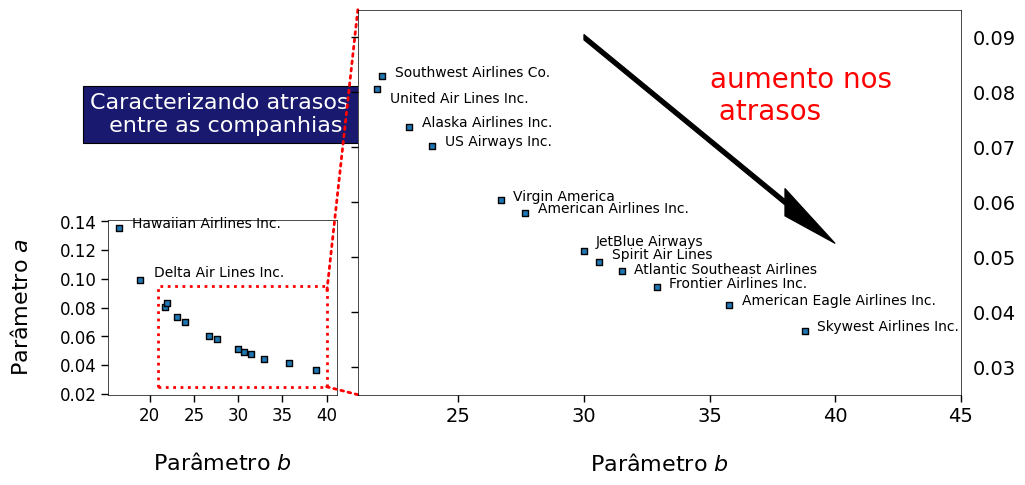

In [23]:
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set_context('paper')

fig = plt.figure(1, figsize=(11, 5))

y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000

x_val = [s[1] for s in pontos]
y_val = [s[0] for s in pontos]

gs = GridSpec(2, 7)

# --
# 1) Plot overview (painel esquerdo)

ax1 = fig.add_subplot(gs[1, 0:2])
plt.scatter(x=x_val, y=y_val, marker='s', edgecolor='black', linewidth=1)

# Label da companhia: Hawaiian airlines

i = 1
ax1.annotate(label_comp[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize=10)
plt.xlabel("Parâmetro $b$", fontsize=16, labelpad=20)
plt.ylabel("Parâmetro $a$", fontsize=16, labelpad=20)

# Label da companhia: Delta airlines

i = 12
ax1.annotate(label_comp[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize=10)
plt.xlabel("Parâmetro $b$", fontsize=16, labelpad=20)
plt.ylabel("Parâmetro $a$", fontsize=16, labelpad=20)

# Título principal

ax1.text(.5, 1.5, 'Caracterizando atrasos \n entre as companhias', fontsize=16,
         bbox={'facecolor': 'midnightblue', 'pad': 5}, color='w',
         horizontalalignment='center', transform=ax1.transAxes)

# Parâmetros das bordas do plot

for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')

# Criando um retângulo

rect = mpatches.Rectangle((21, 0.025), 19, 0.07, linewidth=2, edgecolor='r',
                          linestyle=':', facecolor='none')
ax1.add_patch(rect)

# --
# 2) Zoom no grosso das companhias (painel direito)

ax2 = fig.add_subplot(gs[0:2, 2:])
plt.scatter(x=x_val, y=y_val, marker='s', edgecolor='black', linewidth=1)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21, 45)
ax2.set_ylim(0.025, 0.095)

# Labels das companhias

for i in range(len(abrev_companhias)):
    ax2.annotate(label_comp[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize=10)

# Direção de aumento dos atrasos

ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005, shape='full', head_length=2,
          fc='k', ec='k')
ax2.annotate('aumento nos \n atrasos', fontsize=20, color='r', xy=(35, 0.075),
             xycoords='data')

# Posição e tamanhos dos ticks

plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

# Parâmetros das bordas do plot

for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')

# Conexão entre os dois plots

xy2 = (40, 0.09)
xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data", axesA=ax2,
                      axesB=ax1, linestyle=':', linewidth=2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025)
xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data", axesA=ax2,
                      axesB=ax1, linestyle=':', linewidth=2, color="red")
ax2.add_artist(con)
plt.xlabel("Parâmetro $b$", fontsize=16, labelpad=20)

# --

plt.show()


# Atrasos: na decolagem ou no pouso?


Text(0.5, 0, 'Atraso médio em minutos\n(Na decolagem: azul; No pouso: linhas hachuradas)')

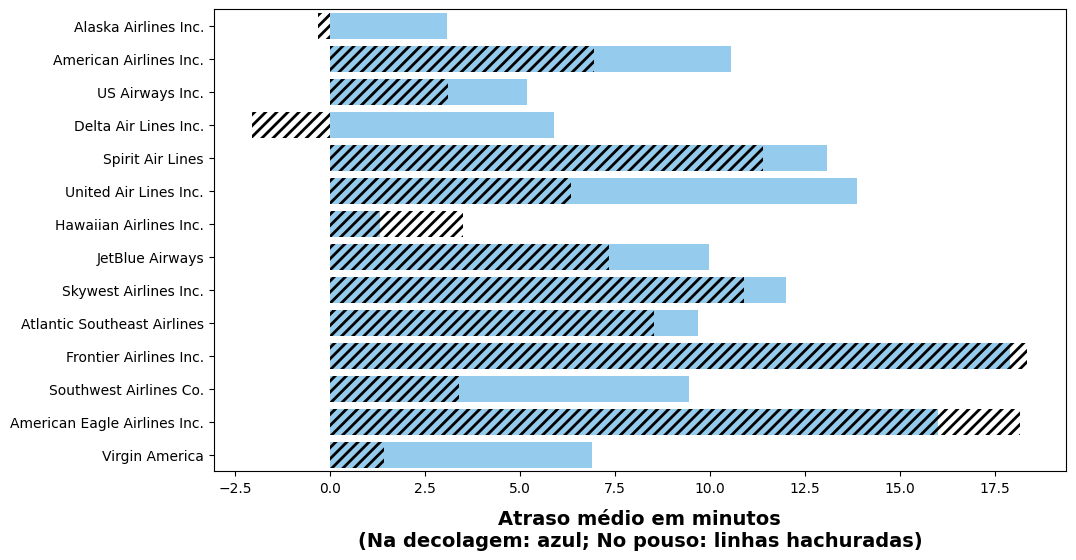

In [25]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0

fig = plt.figure(1, figsize=(11, 6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue",
                 ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch='///',
                 alpha=0.0, ci=None)
labels = [abrev_companhias[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Atraso médio em minutos\n(Na decolagem: azul; No pouso: linhas hachuradas)',
           fontsize=14, weight='bold', labelpad=10)


# Relação entre o aeroporto de origem e os atrasos


In [26]:
print("Número de aeroportos: {}".format(len(df['ORIGIN_AIRPORT'].unique())))


Número de aeroportos: 312


In [27]:
num_origem = dict()
for comp in abrev_companhias.keys():
    list_aeroporto_origem = df[df['AIRLINE']
                               == comp]['ORIGIN_AIRPORT'].unique()
    num_origem[comp] = len(list_aeroporto_origem)


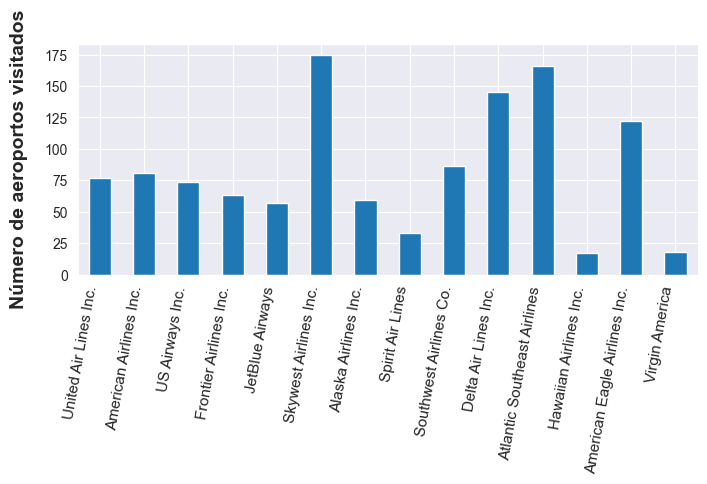

In [28]:
sns.set_style("darkgrid")

df_teste = pd.DataFrame.from_dict(num_origem, orient='index')
df_teste.rename(columns={0: 'contagem'}, inplace=True)

ax = df_teste.plot(kind='bar', figsize=(8, 3))

labels = [abrev_companhias[item.get_text()] for item in ax.get_xticklabels()]

ax.set_xticklabels(labels)
plt.ylabel('Número de aeroportos visitados', fontsize=14, weight='bold',
           labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha='right', rotation=80)

ax.legend().set_visible(False)

plt.show()


In [29]:
atraso_medio_aeroporto = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
atraso_medio_aeroporto.set_index(0, drop=True, inplace=True)

for comp in abrev_companhias.keys():
    df1 = df[df['AIRLINE'] == comp]
    teste = df1['DEPARTURE_DELAY'].groupby(
        df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    atraso_medio_aeroporto[comp] = teste.loc[:, 'média']


In [30]:
aeroportos = pd.read_csv('airports.csv')
id_aeroporto = aeroportos.set_index('IATA_CODE')['CITY'].to_dict()


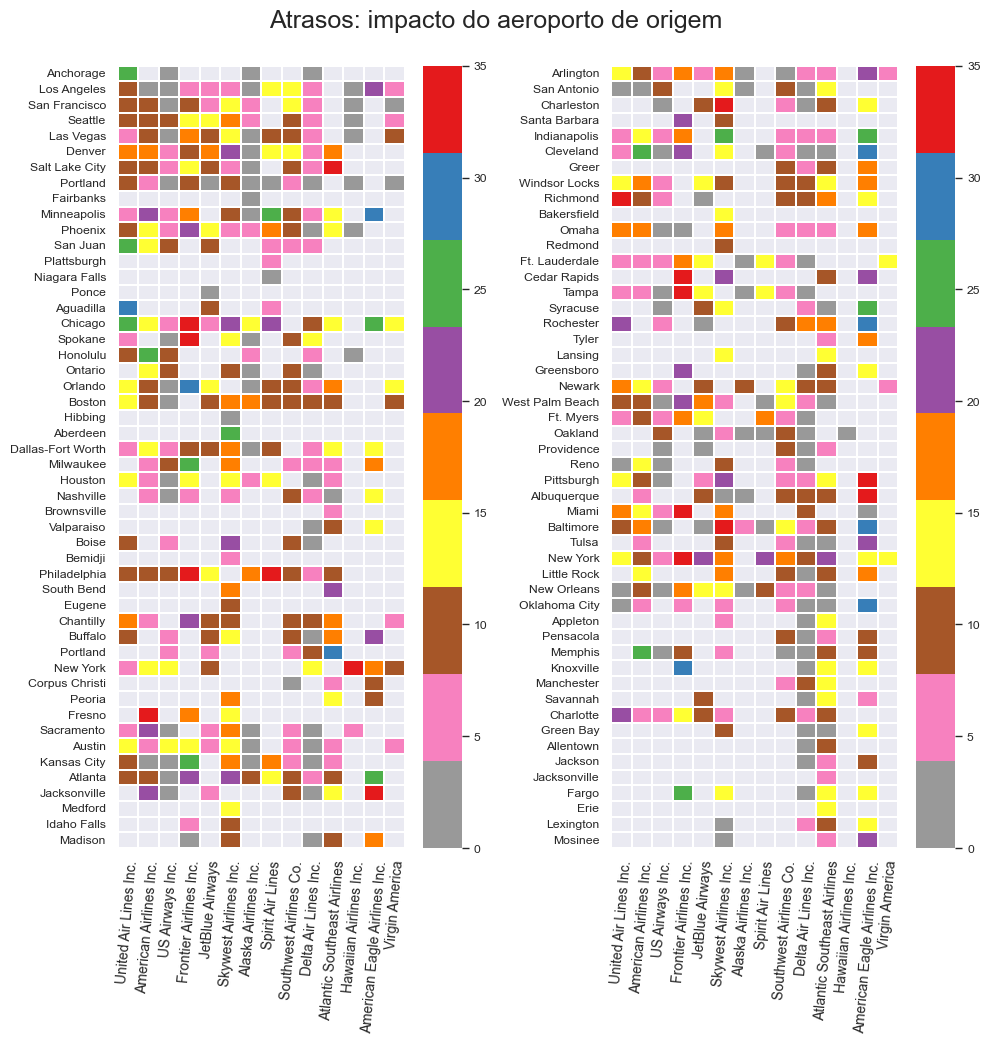

In [31]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
subset = atraso_medio_aeroporto.iloc[:50, :].rename(columns=abrev_companhias)
subset = subset.rename(index=id_aeroporto)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Set1_r", mask=mask, vmin=0,
            vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

# --

ax = fig.add_subplot(1, 2, 2)
subset = atraso_medio_aeroporto.iloc[50:100, :].rename(
    columns=abrev_companhias)
subset = subset.rename(index=id_aeroporto)
fig.text(0.5, 1.02, "Atrasos: impacto do aeroporto de origem", ha='center',
         fontsize=18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Set1_r",
            mask=mask, vmin=0, vmax=35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=85)
ax.yaxis.label.set_visible(False)

plt.tight_layout()


In [32]:
# Selecionando a companhia e criando um subset do dataframe principal

comp = 'AA'
df1 = df[df['AIRLINE'] == comp][['ORIGIN_AIRPORT',
                                 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY']]

# Coletando as rotas e listando os atrasos para cara uma

trajet = dict()
for ind, col in df1.iterrows():
  if pd.isnull(col['DEPARTURE_DELAY']):
    continue
  rota = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
  if rota in trajet.keys():
    trajet[rota].append(col['DEPARTURE_DELAY'])
  else:
    trajet[rota] = [col['DEPARTURE_DELAY']]

# I transpose the dictionary in a list to sort the rotas by origins

list_trajet = []
for key, value in trajet.items():
  list_trajet.append([key, value])
list_trajet.sort()


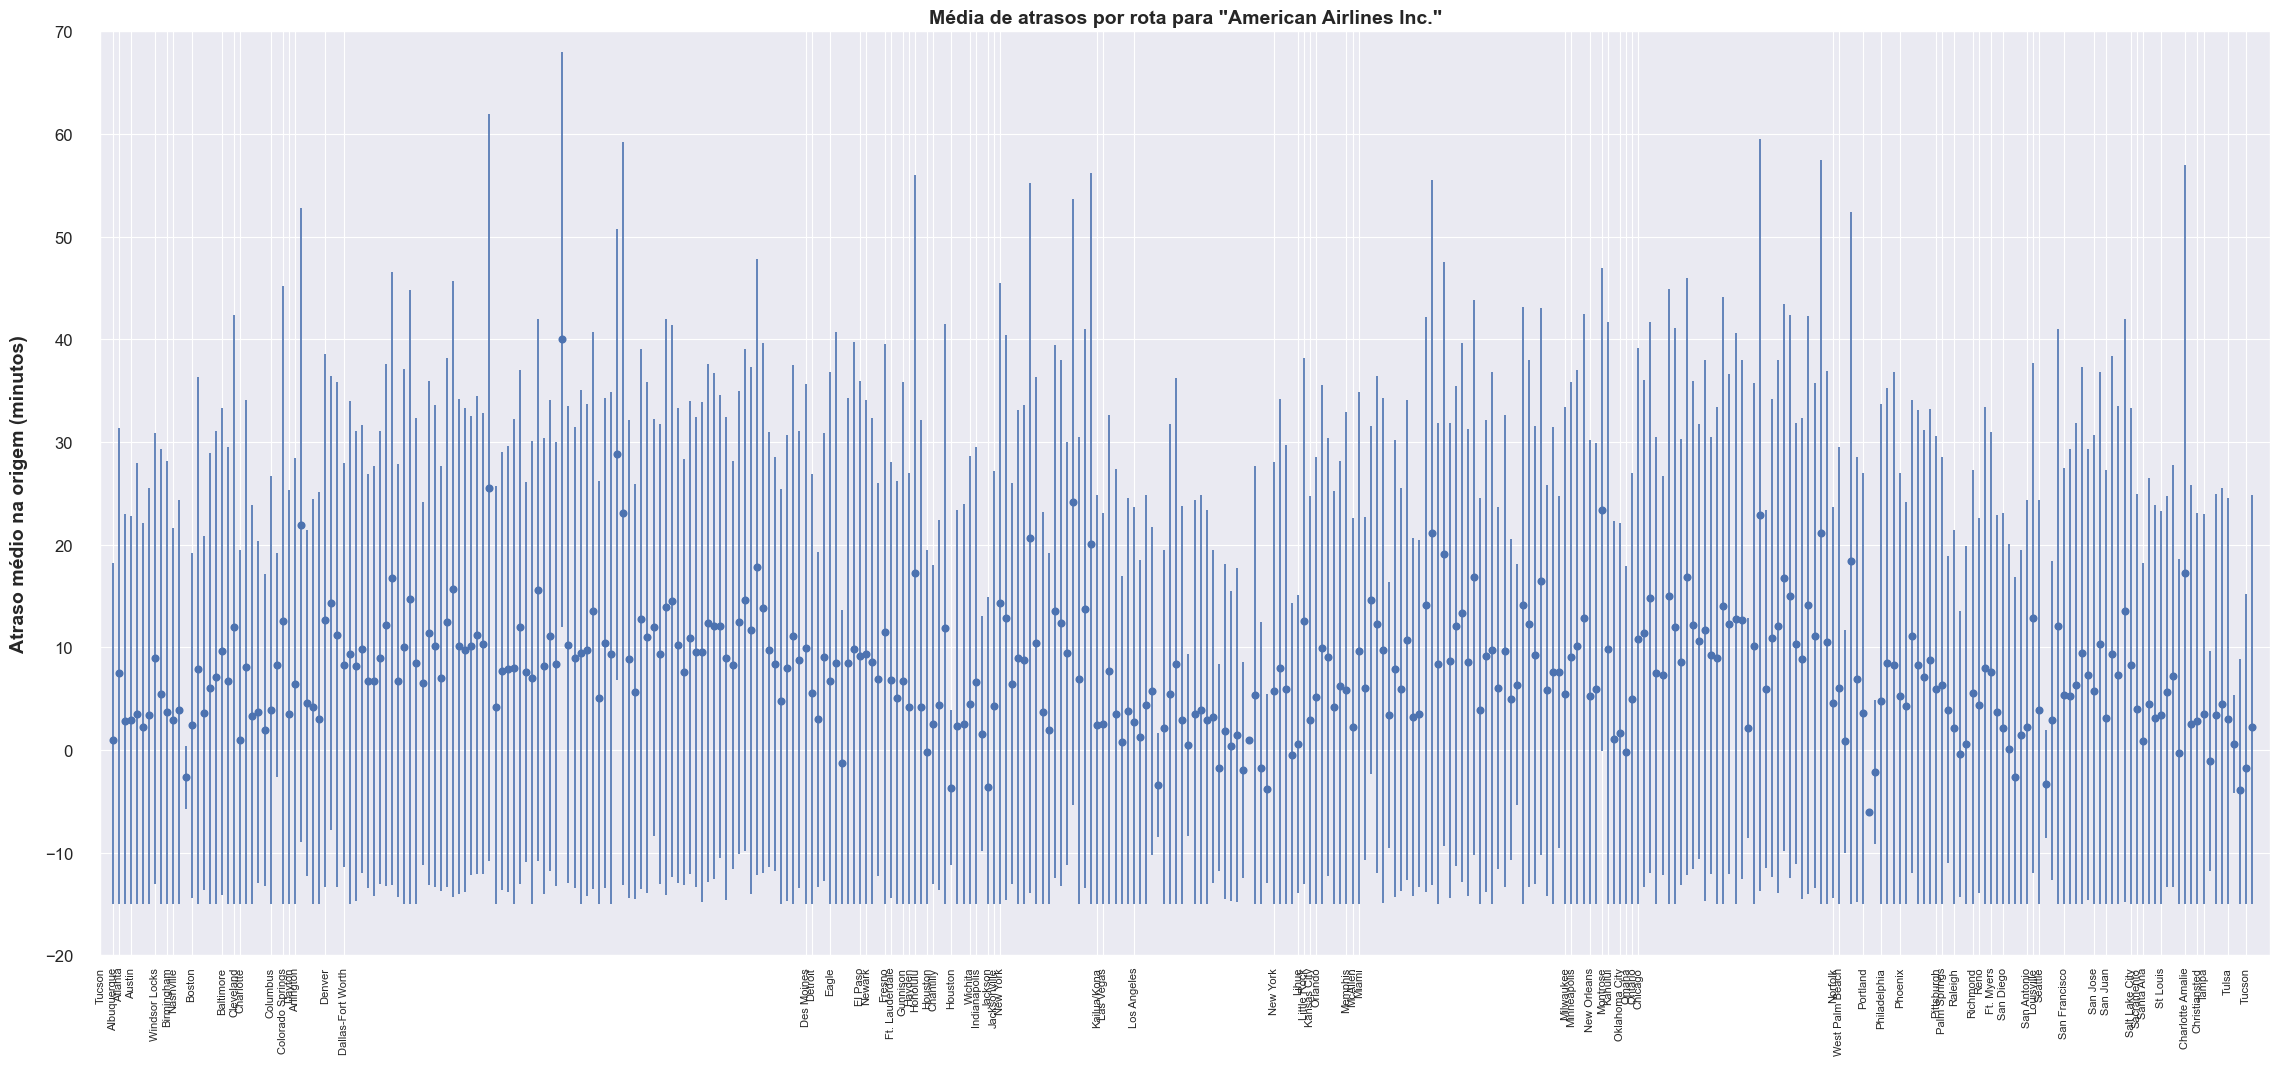

In [33]:
media_val = []
desv_pad_val = []
x_label = []

i = 0
for rota, list_atrasos in list_trajet:

    # Colocando os labels como o aeroporto de origem

    index = rota.split('-')[0]
    x_label.append(id_aeroporto[index])

    # Pondo um limite nos atrasos para impedir que valores muito altos tenham peso excessivo

    trajet2 = [min(90, s) for s in list_atrasos]

    # Calculando a média e o desvio padrão

    media_val.append(scipy.mean(trajet2))
    desv_pad_val.append(scipy.std(trajet2))
    i += 1

# Plotando o gráfico

fig, ax = plt.subplots(figsize=(28, 12))
desv_pad_min = [min(15 + media_val[i], s) for i, s in enumerate(desv_pad_val)]

ax.errorbar(list(range(i)), media_val, yerr=[
            desv_pad_min, desv_pad_val], fmt='o')
ax.set_title('Média de atrasos por rota para "{}"'.format(abrev_companhias[comp]),
             fontsize=14, weight='bold')
plt.ylabel('Atraso médio na origem (minutos)', fontsize=14, weight='bold',
           labelpad=12)

# Definindo x, y, distâncias e posições dos ticks

imin, imax = -2, 353
# Para somente uma fração, usar números entre esses limites, a exemplo do tutorial: 145,230
plt.xlim(imin, imax+2)
plt.ylim(-20, 70)

list_ticks = [imin]
for j in range(imin+1, imax):
    if x_label[j] == x_label[j-1]:
        continue
    list_ticks.append(j)

# Definindo os parâmetros dos ticks

ax.set_xticks(list_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation=90,
                   fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation=0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()


# Variabilidade temporal dos atrasos

In [34]:
class Estilo_da_figura():
    # _________________________________________________________________
    def __init__(self, size_x=11, size_y=5, nrows=1, ncols=1):
        sns.set_style("darkgrid")
        sns.set_context("notebook", font_scale=1.2,
                        rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                                     figsize=(size_x, size_y,))
    # ________________________________
    # Converter self.axs array 2D

        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
        # _____________________________

    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    # _______________

    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size=5)
    # ________________________________________

    def desenhar_legenda(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc=location, shadow=True,
                                                   facecolor='g', frameon=True)
        legend.get_frame().set_facecolor('whitesmoke')
    # ___________________________________________________________________________

    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color=color, linestyle=linestyle,
                                            linewidth=linewidth, marker=marker,
                                            label=label,
                                            markerfacecolor=markerfacecolor,
                                            markersize=markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color=color, linestyle=linestyle,
                                            linewidth=linewidth, label=label)
            self.fig.autofmt_xdate()
    # ________________________________________________________________________

    def cust_plot_date(self, x, y, color='lightblue', linestyle='-', linewidth=1,
                       markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue',
                                             markeredgecolor='grey',
                                             markeredgewidth=markeredgewidth,
                                             label=label)
    # ________________________________________________________________________

    def cust_scatter(self, x, y, color='lightblue', markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                           linewidths=markeredgewidth, label=label)
    # ___________________________________________

    def set_xlabel(self, label, fontsize=14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize=fontsize)
    # ___________________________________________

    def set_ylabel(self, label, fontsize=14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize=fontsize)
    # ____________________________________

    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    # ____________________________________

    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])


In [36]:
comp = 'WN'
id_aeroporto = 4
list_aeroporto_origem = df[df['AIRLINE'] == comp]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == comp) & (df['ARRIVAL_DELAY'] > 0)
      & (df['ORIGIN_AIRPORT'] == list_aeroporto_origem[id_aeroporto])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

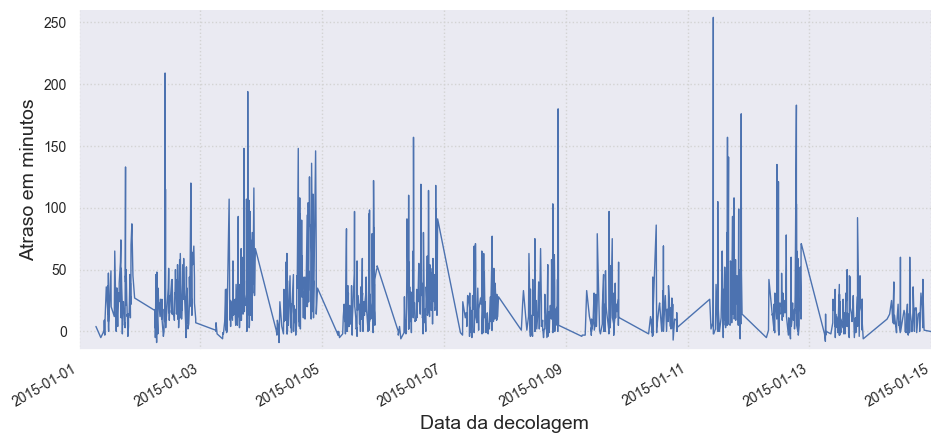

In [37]:
fig1 = Estilo_da_figura(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Atraso em minutos', fontsize = 14)
fig1.set_xlabel('Data da decolagem', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)

In [47]:
#_______________________________
def func2(x, a, b, c):
  return a * x**2 +  b*x + c

#_______________________________
df2['hora_decolagem'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())

test2 = df2['DEPARTURE_DELAY'].groupby(df2['hora_decolagem']).apply(get_stats).unstack()

fct = lambda x:x.hour*3600+x.minute*60+x.second

x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['média']

popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

In [46]:
df2.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL,hora_decolagem
760,WN,PHX,DAL,2015-01-01 06:50:00,06:54:00,4.0,10:00:00,10:04:00,4.0,130.0,130.0,0,06:50:00
2228,WN,PHX,SLC,2015-01-01 08:45:00,08:40:00,-5.0,10:20:00,10:25:00,5.0,95.0,105.0,0,08:45:00
3228,WN,PHX,LAS,2015-01-01 09:55:00,09:55:00,0.0,10:00:00,10:06:00,6.0,65.0,71.0,0,09:55:00
3317,WN,PHX,SAN,2015-01-01 10:00:00,09:59:00,-1.0,10:10:00,10:12:00,2.0,70.0,73.0,0,10:00:00
3405,WN,PHX,LIT,2015-01-01 10:05:00,10:13:00,8.0,13:35:00,13:46:00,11.0,150.0,153.0,1,10:05:00


ConversionError: Failed to convert value(s) to axis units: array([datetime.time(6, 50), datetime.time(8, 45), datetime.time(9, 55),
       ..., datetime.time(19, 50), datetime.time(19, 50),
       datetime.time(19, 50)], dtype=object)

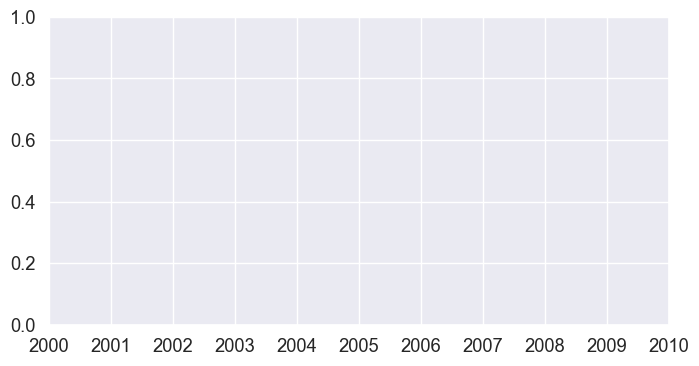

In [48]:
fig1 = Estilo_da_figura(8, 4, 1, 1)

fig1.pos_update(0, 0)

fig1.cust_plot_date(df2['hora_decolagem'], df2['DEPARTURE_DELAY'],
                    markeredge=False, label='pontos de dados iniciais')
fig1.cust_plot(test2.index, test2['média'], linestyle='--', linewidth=2, label='média')
fig1.cust_plot(test2.index, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')

fig1.style()
fig1.draw_legend('upper left')

fig1.set_ylabel('Atraso em minutos', fontsize = 14)
fig1.set_xlabel('Horário de decolagem', fontsize = 14)

fig1.set_ylim(-15, 210)